In [2]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    roc_auc_score,
    confusion_matrix,
    classification_report)
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import seaborn as sns
import tensorflow as tf
from tensorflow.python.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout 
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D
import shap
import lime
import lime.lime_tabular
import anchor
from alibi.explainers import AnchorTabular

In [3]:
dt = pd.read_csv("train_clean.csv")
dt.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,26.822620,265.0,No,49.574949,80.415,High_spent_Small_value_payments,312.49408,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,266.0,No,49.574949,118.280,Low_spent_Large_value_payments,284.62915,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,267.0,No,49.574949,81.700,Low_spent_Medium_value_payments,331.20987,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,268.0,No,49.574949,199.458,Low_spent_Small_value_payments,223.45131,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23.0,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,No,49.574949,41.420,High_spent_Medium_value_payments,341.48923,Good


In [16]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  int64  
 13  Type_of_Loan              100000 non-null  ob

Feature Engineering

In [4]:
# Drop columns that are not useful for the credit scoring problem. 

dt = dt.drop(['ID','Name','Month','SSN', 'Type_of_Loan'],axis=1)

In [5]:
# Calculate the ratio of outstanding debt to annual income

dt['Debt_to_Income_Ratio'] = dt['Outstanding_Debt'] / dt['Annual_Income']

<Axes: xlabel='Debt_to_Income_Ratio', ylabel='Count'>

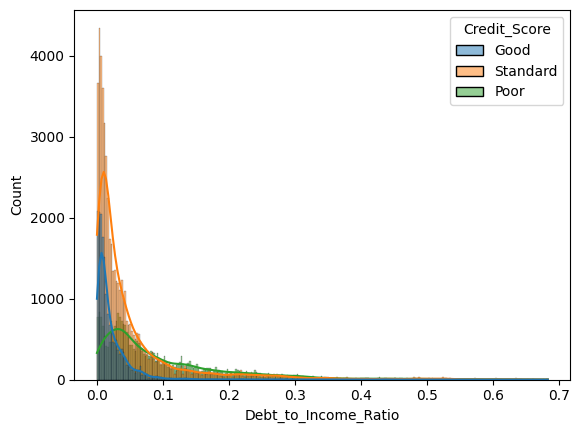

In [8]:
sns.histplot(data=dt, x='Debt_to_Income_Ratio', hue='Credit_Score', kde=True)

ENCODING 

Proper Encoding can significantly impact our model’s performance.

In [6]:
# Select categorical columns
categorical_cols = dt.select_dtypes(include='object').columns

# Select numerical columns
numerical_cols = dt.select_dtypes(include=['int64', 'float64']).columns

print('Num of Numerical Columns: ', len(numerical_cols), 'and Num of Categorical Columns: ', len(categorical_cols))

Num of Numerical Columns:  18 and Num of Categorical Columns:  6


In [7]:
# 1.  Ordinal Encoding for Payment_of_Min_Amount
pay_order = {'Yes':3, 'NM':2, 'No':1}
dt['Payment_of_Min_Amount'] = dt['Payment_of_Min_Amount'].map(pay_order)

# 2. Ordinal Encoding for Credit_Mix 
mix_order = {'Bad': 1, 'Standard': 2, 'Good': 3}
dt['Credit_Mix'] = dt['Credit_Mix'].map(mix_order)

# 3.  Convert nominal variables to dummy variables with One-Hot Encoding
#dt = pd.get_dummies(dt, columns=['Occupation', 'Payment_Behaviour'], drop_first=True)

label_encoder = LabelEncoder()

dt['Occupation'] = label_encoder.fit_transform(dt['Occupation'])                # # models performed worse with this encoding method. # #
dt['Payment_Behaviour'] = label_encoder.fit_transform(dt['Payment_Behaviour'])

# 4. Encoding for target variable
dt['Credit_Score'] = label_encoder.fit_transform(dt['Credit_Score'])


In [25]:
dt

,Customer_ID,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,CUS_0xd40,23.0,19114.12,1824.843333,3,4,3,4,3,7.0,...,False,False,True,False,False,False,True,False,False,False
1,CUS_0xd40,23.0,19114.12,1824.843333,3,4,3,4,-1,7.0,...,False,False,True,False,False,False,False,True,False,False
2,CUS_0xd40,23.0,19114.12,1824.843333,3,4,3,4,3,7.0,...,False,False,True,False,False,False,False,False,True,False
3,CUS_0xd40,23.0,19114.12,1824.843333,3,4,3,4,5,7.0,...,False,False,True,False,False,False,False,False,False,True
4,CUS_0xd40,23.0,19114.12,1824.843333,3,4,3,4,6,7.0,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CUS_0x942c,25.0,39628.99,3359.415833,4,6,7,2,23,6.0,...,False,False,False,False,False,False,False,False,False,False
99996,CUS_0x942c,25.0,39628.99,3359.415833,4,6,7,2,18,6.0,...,False,False,False,False,False,True,False,False,False,False
99997,CUS_0x942c,25.0,39628.99,3359.415833,4,6,7,2,27,6.0,...,False,False,False,False,False,False,False,False,False,False
99998,CUS_0x942c,25.0,39628.99,3359.415833,4,6,7,2,20,6.0,...,False,False,False,False,False,False,False,True,False,False


Evaluation Metrics

Accuracy is less informative for imbalanced datasets, but Precision, Recall, and F1-Score are more insightful. Also, Weighted Average weights metrics by class frequency.

Confusion Matrix plot provides a matrix showing True Positives, True Negatives, False Positives, and False Negatives for each class, which helps identify which classes the model struggles with.

Logarithmic Loss (Log Loss) evaluates the uncertainty of the model's predictions by considering predicted probabilities.

Gini Index is commonly used in credit scoring as a measure of rank-ordering ability.

The type II error is more costly in credit scoring, since Type II (False Negative ratio) predicts a borrower as a good borrower but in actual
fact he or she is a bad borrower.

Area Under the ROC Curve (AUC-ROC) Evaluates the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR) for each class.


In [8]:
def score(y_true, y_pred,y_proba):

    # Accuracy
    acc = accuracy_score(y_true, y_pred)* 100
    
    # Precision, Recall, F1-Score (weighted)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    precision = precision * 100
    recall = recall * 100
    f1 = f1 * 100
    
    # Log Loss
    logloss = log_loss(y_true, y_proba)* 100
    
    # Gini Index
    auc = roc_auc_score(label_binarize(y_true, classes=np.unique(y_true)), y_proba, average="macro")
    gini_index =(2 * auc - 1)* 100

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Type II Errors (Predicted as "Good" but actually "Bad" or "Standard")
    labels = np.unique(y_true)
    good_index = np.where(labels == 0)[0][0]
    type_ii_error = cm[:, good_index].sum() - cm[good_index, good_index]

    total_predictions = len(y_true)
    type_ii_error_percentage = (type_ii_error / total_predictions) * 100

    
    # Confusion Matrix Plot
    plt.figure(figsize=(4,2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    return {
        "Accuracy (%)": f"{acc:.2f}",
        "Precision (Weighted, %)": f"{precision:.2f}",
        "Recall (Weighted, %)": f"{recall:.2f}",
        "F1-Score (Weighted, %)": f"{f1:.2f}",
        "Log Loss (%)": f"{logloss:.2f}",
        "Gini Index (%)": f"{gini_index:.2f}",
        "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": type_ii_error,
        "Type II Error Percentage": f"{type_ii_error_percentage:.2f}"
    }


In [9]:
def ROC_Curve(y_true, y_proba):
    
    """
    Plot ROC curves and calculate AUC-ROC scores for a multiclass model.

    """
    # Binarize true labels for multi-class ROC
    classes = np.unique(y_true)
    y_bin = label_binarize(y_true, classes=classes)
    
    # Compute ROC and AUC for each class
    plt.figure(figsize=(6, 4))
    for i, class_label in enumerate(classes):
        from sklearn.metrics import roc_curve, auc
        
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc:.2f})")
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [10]:
# Split the dataset

# Separate features and target
X = dt.drop(['Credit_Score','Customer_ID'], axis=1)
y = dt['Credit_Score']

# Standardization of numerical columns:
sc=StandardScaler()
X[numerical_cols]=sc.fit_transform(X[numerical_cols])

# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Further stratified split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# Check class distribution
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("Validation class distribution:")
print(y_val.value_counts(normalize=True))

print("Test class distribution:")
print(y_test.value_counts(normalize=True))

#y_train = to_categorical(y_train, num_classes=3) 
#y_val = to_categorical(y_val, num_classes=3) 

Train class distribution:
Credit_Score
2    0.531736
1    0.289986
0    0.178278
Name: proportion, dtype: float64
Validation class distribution:
Credit_Score
2    0.53175
1    0.29000
0    0.17825
Name: proportion, dtype: float64
Test class distribution:
Credit_Score
2    0.53175
1    0.28995
0    0.17830
Name: proportion, dtype: float64


Now, we are ready to start experimenting ! 

625/625 [==============================] - 2s 2ms/step


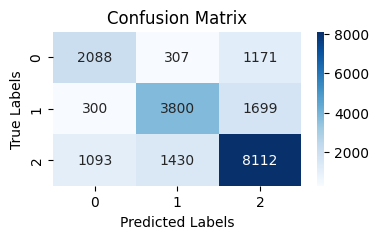

{'Accuracy (%)': '70.00',
 'Precision (Weighted, %)': '69.87',
 'Recall (Weighted, %)': '70.00',
 'F1-Score (Weighted, %)': '69.91',
 'Log Loss (%)': '68.01',
 'Gini Index (%)': '70.03',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1393,
 'Type II Error Percentage': '6.97'}

In [11]:
model = models.Sequential([
        layers.Dense(128, input_dim=X_train.shape[1], activation='relu'),
        layers.Dense(64, activation="relu"),
        layers.Dense(3, activation='softmax') 
    ])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
hist=model.fit(X_train,
               y_train,
               epochs=5,
               batch_size=64,
               validation_data=(X_val,y_val),
               verbose=0)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label


score(y_true, y_pred,y_proba)

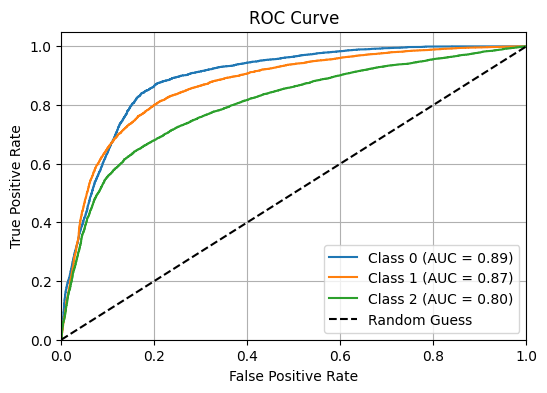

In [12]:
# Plot the ROC-CURVE 
ROC_Curve(y_true, y_proba)

In [12]:
import shap
explainer = shap.KernelExplainer(model=model.predict, data=X.head(50), link="identity")
shap_values = explainer.shap_values(X=X.iloc[0:50, :], nsamples=100,verbose=0)

2/2 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

157/157 [==============================] - 0s 3ms/step


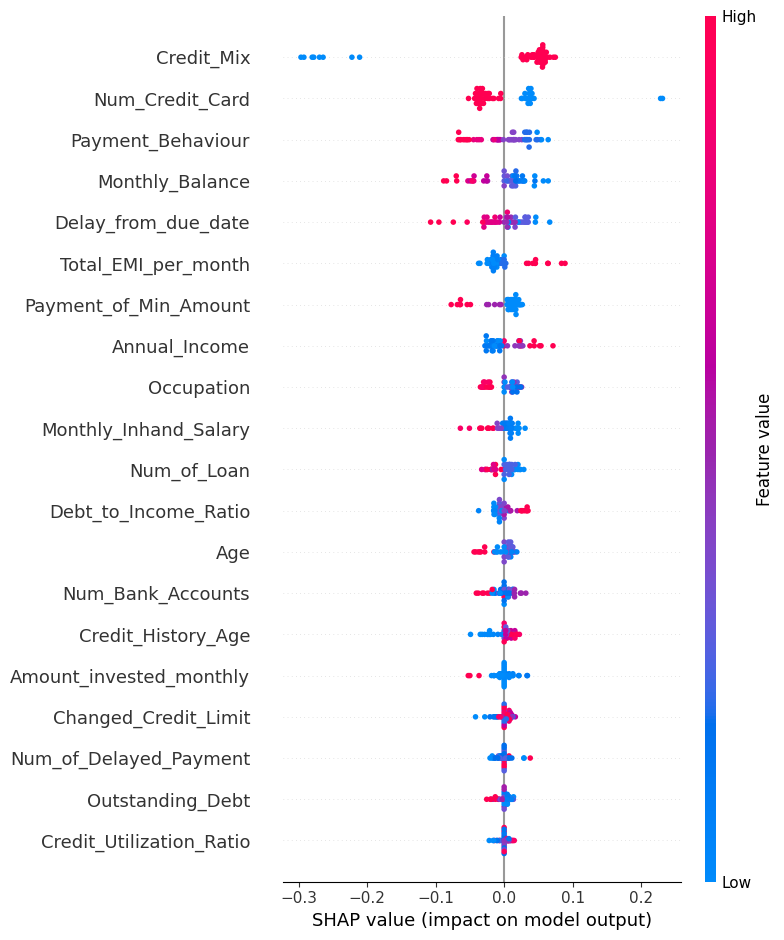

In [14]:
# Summary plot for credit score 'Good'
shap.summary_plot(shap_values=shap_values[:,:,0], features=X.iloc[0:50, :])

This plot gives clear explanations on how a customer can be classified as 'Good' by the model. The most influential variables are credit mix, number of credit cards, payment behaviour and so on.

In [13]:
y_proba = model.predict(X_test.iloc[0:11])  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_pred = pd.Series(y_pred,name='prediction')
y_true = pd.Series(y_test.iloc[0:11].values, name = 'true score')
pd.DataFrame([y_true,y_pred])
# Data to experiment with: 

1/1 [==============================] - 0s 79ms/step


,0,1,2,3,4,5,6,7,8,9,10
true score,1,1,1,2,2,2,2,2,2,2,1
prediction,1,1,1,2,2,0,2,2,2,2,2


In [17]:
#  Base values for each class
print(explainer.expected_value)

[0.39577725 0.1493697  0.45485305]


In [16]:
# Customer 0 was correctly classified as 'Poor' credit risk

X_idx = 0
shap_value_single = explainer.shap_values(X=X.iloc[X_idx : X_idx + 1, :], nsamples=100)


shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_value_single[:,:,1],
    features=X.iloc[X_idx : X_idx + 1, :],
)

  0%|          | 0/1 [00:00<?, ?it/s]

157/157 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 43ms/step


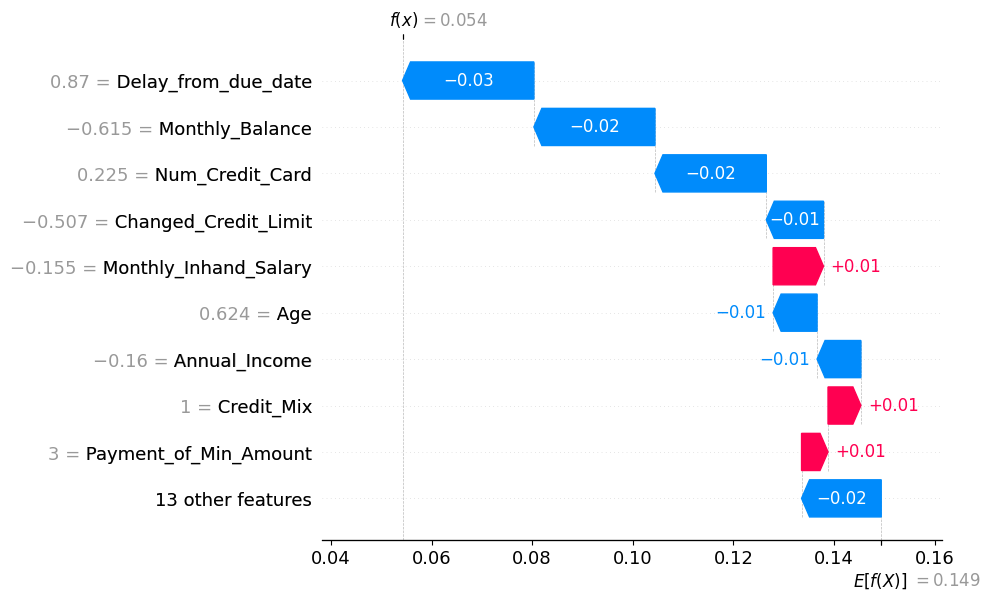

In [22]:
# Waterfall plot
row = 0
explainer = shap.KernelExplainer(model=model.predict, data=X.head(50), link="identity")

shap.waterfall_plot(shap.Explanation(values=shap_values[:,:,1][row], base_values=explainer.expected_value[1], 
                                     data=X_test.iloc[row], feature_names= X_test.columns.tolist()))

In [19]:
# LIME explains individual predictions by approximating the model locally with an interpretable, simpler model (e.g., a linear model).
# It helps understand how the model behaves for a specific instance.

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Good', 'Poor', 'Standard'],
                                                   mode='classification')

# Explain instance 0 prediction
exp = explainer.explain_instance(X_test.iloc[0].values, model.predict)

# Show explanation
exp.show_in_notebook()

157/157 [==============================] - 0s 3ms/step


In [20]:
# Anchor explanation

# Initialize the AnchorTabular explainer
explainer = AnchorTabular(model.predict, feature_names=list(X_test.columns))

# Fit the explainer on the training data
explainer.fit(X_train.to_numpy(), disc_perc=[25, 50, 75])

# Explain a single prediction (Customer 0)
idx = 0  # Index of the instance to explain
instance = X_test.iloc[idx].to_numpy().reshape(1, -1)
explanation = explainer.explain(instance)

# Print the explanation
print('Anchor:', explanation.anchor)
print('Precision:', explanation.precision)
print('Coverage:', explanation.coverage)

4/4 [==============================] - 0s 5ms/step
Anchor: ['Delay_from_due_date > 0.47', 'Changed_Credit_Limit <= -0.14', 'Interest_Rate > 0.63']
Precision: 0.9745454545454545
Coverage: 0.0559


We used 3 XAI methods to explain the prediction of customer 0 as Poor. From SHAP plots we see that delay from due date, monthly balance and number of credit cards pushed the model to lower values, while according to lime delay from due date, interest rate and number of credit inquiries were the most influential variables. The anchor explainer tels us that if the 3 conditions hold, the model prediction is accurate by 97,5%.  These conditions apply to about 5.6% of the customers in the dataset.

In [24]:
# Anchor explanation

# Explain a single prediction (Customer 1)
idx = 1  # Index of the instance to explain
instance = X_test.iloc[idx].to_numpy().reshape(1, -1)
explanation = explainer.explain(instance)

# Print the explanation
print('Anchor:', explanation.anchor)
print('Precision:', explanation.precision)
print('Coverage:', explanation.coverage)

4/4 [==============================] - 0s 7ms/step
Anchor: ['Delay_from_due_date > 0.47', 'Changed_Credit_Limit <= -0.74', 'Debt_to_Income_Ratio > 0.11', 'Interest_Rate > 0.63']
Precision: 0.9870967741935484
Coverage: 0.0164


The anchor now outputs the same 3 conditions in order for a customer to be classified as poor credit risk with hugh accuracy.

Epoch 1/50
1125/1125 [==============================] - 7s 4ms/step - loss: 0.7922 - accuracy: 0.6298 - val_loss: 0.7020 - val_accuracy: 0.6859
Epoch 2/50
1125/1125 [==============================] - 5s 4ms/step - loss: 0.7250 - accuracy: 0.6716 - val_loss: 0.6928 - val_accuracy: 0.6961
Epoch 3/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.7084 - accuracy: 0.6813 - val_loss: 0.6798 - val_accuracy: 0.7005
Epoch 4/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.7009 - accuracy: 0.6884 - val_loss: 0.6743 - val_accuracy: 0.7026
Epoch 5/50
1125/1125 [==============================] - 6s 6ms/step - loss: 0.6934 - accuracy: 0.6916 - val_loss: 0.6725 - val_accuracy: 0.7046
Epoch 6/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.6866 - accuracy: 0.6970 - val_loss: 0.6745 - val_accuracy: 0.7095
Epoch 7/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.6826 - accuracy: 0.6967 - val_loss: 0.6705 - val_accuracy:

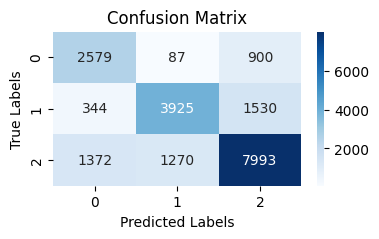

{'Accuracy (%)': '72.48',
 'Precision (Weighted, %)': '73.03',
 'Recall (Weighted, %)': '72.48',
 'F1-Score (Weighted, %)': '72.61',
 'Log Loss (%)': '63.28',
 'Gini Index (%)': '73.78',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1716,
 'Type II Error Percentage': '8.58'}

In [89]:
# Add dropout layer to the model.
# Dropout prevents overfitting by randomly dropping some neurons during training.

model = Sequential([
    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    Dropout(0.3),

    Dense(64, activation='relu'),  # Second hidden layer
    Dropout(0.3),

    Dense(32, activation='relu'),  # Third hidden layer
    Dropout(0.2),

    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    X_train, y_train,  
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),  
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label


score(y_true, y_pred,y_proba)

Adding dropout layers resulted in better accuracy, but worse Type 2 error percentage.

Epoch 1/50
1125/1125 [==============================] - 7s 4ms/step - loss: 0.7992 - accuracy: 0.6269 - val_loss: 0.7062 - val_accuracy: 0.6841
Epoch 2/50
1125/1125 [==============================] - 5s 4ms/step - loss: 0.7309 - accuracy: 0.6722 - val_loss: 0.6941 - val_accuracy: 0.6909
Epoch 3/50
1125/1125 [==============================] - 5s 4ms/step - loss: 0.7114 - accuracy: 0.6827 - val_loss: 0.6848 - val_accuracy: 0.7039
Epoch 4/50
1125/1125 [==============================] - 4s 4ms/step - loss: 0.7012 - accuracy: 0.6891 - val_loss: 0.6766 - val_accuracy: 0.7032
Epoch 5/50
1125/1125 [==============================] - 5s 4ms/step - loss: 0.6937 - accuracy: 0.6933 - val_loss: 0.6719 - val_accuracy: 0.7041
Epoch 6/50
1125/1125 [==============================] - 5s 4ms/step - loss: 0.6913 - accuracy: 0.6954 - val_loss: 0.6668 - val_accuracy: 0.7066
Epoch 7/50
1125/1125 [==============================] - 4s 4ms/step - loss: 0.6857 - accuracy: 0.6969 - val_loss: 0.6678 - val_accuracy:

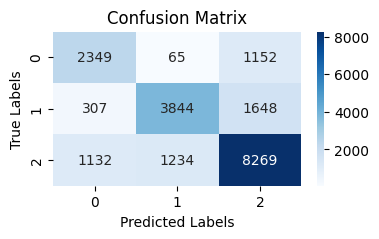

{'Accuracy (%)': '72.31',
 'Precision (Weighted, %)': '72.45',
 'Recall (Weighted, %)': '72.31',
 'F1-Score (Weighted, %)': '72.28',
 'Log Loss (%)': '63.41',
 'Gini Index (%)': '73.61',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1439,
 'Type II Error Percentage': '7.20'}

In [90]:
# Add BatchNormalization to the model.
# BatchNormalization stabilizes training by normalizing inputs to each layer.

model = Sequential([
    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),  # Third hidden layer
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),  # Validation data
 #   callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label


score(y_true, y_pred,y_proba)

Type 2 error dicreased.

Epoch 1/50
1125/1125 [==============================] - 9s 5ms/step - loss: 0.8632 - accuracy: 0.6102 - val_loss: 0.7060 - val_accuracy: 0.6851
Epoch 2/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7377 - accuracy: 0.6650 - val_loss: 0.6886 - val_accuracy: 0.6919
Epoch 3/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7147 - accuracy: 0.6786 - val_loss: 0.6782 - val_accuracy: 0.7016
Epoch 4/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7057 - accuracy: 0.6863 - val_loss: 0.6720 - val_accuracy: 0.7044
Epoch 5/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.6986 - accuracy: 0.6898 - val_loss: 0.6698 - val_accuracy: 0.7032
Epoch 6/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.6945 - accuracy: 0.6922 - val_loss: 0.6673 - val_accuracy: 0.7067
Epoch 7/50
1125/1125 [==============================] - 11s 10ms/step - loss: 0.6908 - accuracy: 0.6938 - val_loss: 0.6648 - val_accurac

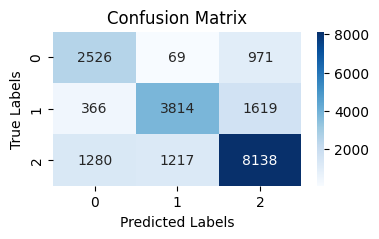

{'Accuracy (%)': '72.39',
 'Precision (Weighted, %)': '72.82',
 'Recall (Weighted, %)': '72.39',
 'F1-Score (Weighted, %)': '72.45',
 'Log Loss (%)': '63.61',
 'Gini Index (%)': '73.62',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1646,
 'Type II Error Percentage': '8.23'}

In [91]:
# Early Stopping: Monitors validation loss and stops training if it doesn’t improve for 5 consecutive epochs.

model = Sequential([
    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),  # Third hidden layer
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)

Epoch 1/50
1125/1125 [==============================] - 8s 5ms/step - loss: 0.8350 - accuracy: 0.6281 - val_loss: 0.7029 - val_accuracy: 0.6852
Epoch 2/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.7266 - accuracy: 0.6740 - val_loss: 0.6908 - val_accuracy: 0.6989
Epoch 3/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.7101 - accuracy: 0.6835 - val_loss: 0.6813 - val_accuracy: 0.7009
Epoch 4/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7042 - accuracy: 0.6868 - val_loss: 0.6767 - val_accuracy: 0.7042
Epoch 5/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.6956 - accuracy: 0.6924 - val_loss: 0.6726 - val_accuracy: 0.7085
Epoch 6/50
1125/1125 [==============================] - 6s 5ms/step - loss: 0.6921 - accuracy: 0.6923 - val_loss: 0.6653 - val_accuracy: 0.7042
Epoch 7/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.6888 - accuracy: 0.6941 - val_loss: 0.6661 - val_accuracy:

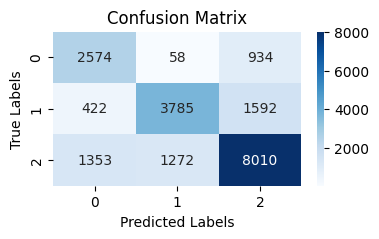

{'Accuracy (%)': '71.84',
 'Precision (Weighted, %)': '72.43',
 'Recall (Weighted, %)': '71.84',
 'F1-Score (Weighted, %)': '71.95',
 'Log Loss (%)': '63.81',
 'Gini Index (%)': '73.45',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1775,
 'Type II Error Percentage': '8.88'}

In [107]:
# Less hidden layers

model = Sequential([
    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)


# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),  # Validation data
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)

Performance dropped with less hidden layers in the model.

Epoch 1/50
1125/1125 [==============================] - 10s 6ms/step - loss: 0.8544 - accuracy: 0.6057 - val_loss: 0.7786 - val_accuracy: 0.6697
Epoch 2/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7568 - accuracy: 0.6564 - val_loss: 0.7475 - val_accuracy: 0.6775
Epoch 3/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.7345 - accuracy: 0.6661 - val_loss: 0.7492 - val_accuracy: 0.6800
Epoch 4/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.7249 - accuracy: 0.6698 - val_loss: 0.7406 - val_accuracy: 0.6808
Epoch 5/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7170 - accuracy: 0.6728 - val_loss: 0.7333 - val_accuracy: 0.6819
Epoch 6/50
1125/1125 [==============================] - 8s 7ms/step - loss: 0.7131 - accuracy: 0.6717 - val_loss: 0.7288 - val_accuracy: 0.6826
Epoch 7/50
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7079 - accuracy: 0.6749 - val_loss: 0.7357 - val_accuracy

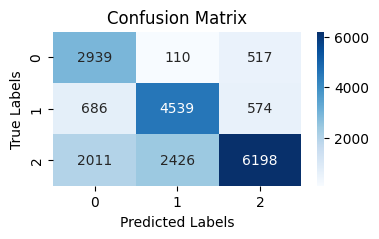

{'Accuracy (%)': '68.38',
 'Precision (Weighted, %)': '73.12',
 'Recall (Weighted, %)': '68.38',
 'F1-Score (Weighted, %)': '68.61',
 'Log Loss (%)': '70.98',
 'Gini Index (%)': '71.55',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 2697,
 'Type II Error Percentage': '13.48'}

In [113]:
#  Using Class Weights to deal with imbalanced data.
# Class weights modify the loss function, giving more importance to misclassifications of the minority class.

model = Sequential([
    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),  # Third hidden layer
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compute class weights
y_train_categorical = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_categorical),
    y=y_train_categorical
)
class_weights_dict = dict(enumerate(class_weights))

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)

class weights don’t increase evaluation metrics.

Epoch 1/100
1125/1125 [==============================] - 11s 7ms/step - loss: 0.8549 - accuracy: 0.6097 - val_loss: 0.7063 - val_accuracy: 0.6830
Epoch 2/100
1125/1125 [==============================] - 8s 7ms/step - loss: 0.7350 - accuracy: 0.6654 - val_loss: 0.6871 - val_accuracy: 0.6923
Epoch 3/100
1125/1125 [==============================] - 7s 7ms/step - loss: 0.7123 - accuracy: 0.6766 - val_loss: 0.6808 - val_accuracy: 0.6971
Epoch 4/100
1125/1125 [==============================] - 7s 6ms/step - loss: 0.7056 - accuracy: 0.6851 - val_loss: 0.6728 - val_accuracy: 0.7009
Epoch 5/100
1125/1125 [==============================] - 7s 7ms/step - loss: 0.6991 - accuracy: 0.6883 - val_loss: 0.6730 - val_accuracy: 0.7038
Epoch 6/100
1125/1125 [==============================] - 7s 7ms/step - loss: 0.6944 - accuracy: 0.6918 - val_loss: 0.6682 - val_accuracy: 0.7042
Epoch 7/100
1125/1125 [==============================] - 7s 7ms/step - loss: 0.6926 - accuracy: 0.6948 - val_loss: 0.6672 - val_a

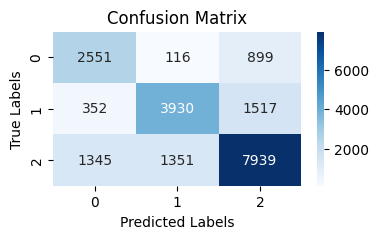

{'Accuracy (%)': '72.10',
 'Precision (Weighted, %)': '72.59',
 'Recall (Weighted, %)': '72.10',
 'F1-Score (Weighted, %)': '72.22',
 'Log Loss (%)': '63.50',
 'Gini Index (%)': '73.51',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1697,
 'Type II Error Percentage': '8.48'}

In [114]:
# Increase epochs from 50 to 100

model = Sequential([
    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),  # Third hidden layer
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)

Neither epochs=100 ended in better performance. Early stopping stopped training after 65 epochs as the accuracy wasn't getting better for 5 consecutive epochs.

Using SMOTE (Synthetic Minority Oversampling Technique) can be an effective way to handle imbalanced datasets if class weights do not improve performance. SMOTE generates synthetic examples for the minority class by interpolating between existing samples, thereby increasing the representation of the minority class without duplication.


Epoch 1/60
898/898 [==============================] - 19s 13ms/step - loss: 0.7664 - accuracy: 0.6804 - val_loss: 0.7113 - val_accuracy: 0.6815
Epoch 2/60
898/898 [==============================] - 11s 13ms/step - loss: 0.6415 - accuracy: 0.7338 - val_loss: 0.6957 - val_accuracy: 0.6925
Epoch 3/60
898/898 [==============================] - 12s 14ms/step - loss: 0.6120 - accuracy: 0.7451 - val_loss: 0.6796 - val_accuracy: 0.6981
Epoch 4/60
898/898 [==============================] - 13s 15ms/step - loss: 0.5980 - accuracy: 0.7489 - val_loss: 0.6727 - val_accuracy: 0.6994
Epoch 5/60
898/898 [==============================] - 12s 14ms/step - loss: 0.5904 - accuracy: 0.7516 - val_loss: 0.6769 - val_accuracy: 0.7007
Epoch 6/60
898/898 [==============================] - 12s 13ms/step - loss: 0.5827 - accuracy: 0.7561 - val_loss: 0.6639 - val_accuracy: 0.7069
Epoch 7/60
898/898 [==============================] - 11s 13ms/step - loss: 0.5781 - accuracy: 0.7568 - val_loss: 0.6625 - val_accuracy:

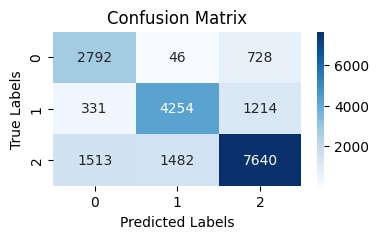

{'Accuracy (%)': '73.43',
 'Precision (Weighted, %)': '74.47',
 'Recall (Weighted, %)': '73.43',
 'F1-Score (Weighted, %)': '73.63',
 'Log Loss (%)': '60.68',
 'Gini Index (%)': '75.64',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1844,
 'Type II Error Percentage': '9.22'}

In [152]:
# SMOTE 

# SMOTE should only be applied to the training data, not the test or validation sets.
# Separate features and target
X = dt.drop(['Credit_Score','Customer_ID'], axis=1)
y = dt['Credit_Score']


# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Further stratified split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# Resample the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train = to_categorical(y_train, num_classes=3) 
y_val = to_categorical(y_val, num_classes=3) 

# Scale the training, validation, and test sets
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

model = Sequential([
    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, input_dim=39, activation='relu'),  # First hidden layer
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),  # Third hidden layer
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=60,
    batch_size=128,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)

Epoch 1/60
898/898 [==============================] - 37s 37ms/step - loss: 0.7234 - accuracy: 0.7001 - val_loss: 0.7024 - val_accuracy: 0.6899
Epoch 2/60
898/898 [==============================] - 35s 39ms/step - loss: 0.6127 - accuracy: 0.7428 - val_loss: 0.6755 - val_accuracy: 0.7016
Epoch 3/60
898/898 [==============================] - 33s 37ms/step - loss: 0.5908 - accuracy: 0.7528 - val_loss: 0.6702 - val_accuracy: 0.7056
Epoch 4/60
898/898 [==============================] - 35s 39ms/step - loss: 0.5788 - accuracy: 0.7572 - val_loss: 0.6722 - val_accuracy: 0.6924
Epoch 5/60
898/898 [==============================] - 33s 37ms/step - loss: 0.5721 - accuracy: 0.7597 - val_loss: 0.6787 - val_accuracy: 0.7051
Epoch 6/60
898/898 [==============================] - 33s 37ms/step - loss: 0.5626 - accuracy: 0.7634 - val_loss: 0.6568 - val_accuracy: 0.7117
Epoch 7/60
898/898 [==============================] - 38s 43ms/step - loss: 0.5541 - accuracy: 0.7673 - val_loss: 0.6677 - val_accuracy:

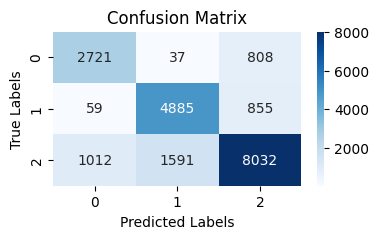

{'Accuracy (%)': '78.19',
 'Precision (Weighted, %)': '78.60',
 'Recall (Weighted, %)': '78.19',
 'F1-Score (Weighted, %)': '78.21',
 'Log Loss (%)': '52.82',
 'Gini Index (%)': '81.19',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1071,
 'Type II Error Percentage': '5.36'}

In [19]:
# Deepening the model.

X = dt.drop(['Credit_Score','Customer_ID'], axis=1)
y = dt['Credit_Score']


# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Further stratified split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# Resample the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train = to_categorical(y_train, num_classes=3) 
y_val = to_categorical(y_val, num_classes=3) 

model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Scale the training, validation, and test sets
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=60,
    batch_size=128,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)                   

Epoch 1/100
449/449 [==============================] - 47s 90ms/step - loss: 0.7533 - accuracy: 0.6904 - val_loss: 0.7008 - val_accuracy: 0.6911
Epoch 2/100
449/449 [==============================] - 36s 81ms/step - loss: 0.5722 - accuracy: 0.7596 - val_loss: 0.6722 - val_accuracy: 0.7069
Epoch 6/100
449/449 [==============================] - 32s 72ms/step - loss: 0.5643 - accuracy: 0.7619 - val_loss: 0.6571 - val_accuracy: 0.7115
Epoch 7/100
449/449 [==============================] - 39s 87ms/step - loss: 0.5563 - accuracy: 0.7649 - val_loss: 0.6582 - val_accuracy: 0.7084
Epoch 8/100
449/449 [==============================] - 52s 116ms/step - loss: 0.5491 - accuracy: 0.7689 - val_loss: 0.6666 - val_accuracy: 0.7076
Epoch 9/100
449/449 [==============================] - 63s 140ms/step - loss: 0.5422 - accuracy: 0.7724 - val_loss: 0.6512 - val_accuracy: 0.7176
Epoch 10/100
449/449 [==============================] - 45s 100ms/step - loss: 0.5361 - accuracy: 0.7739 - val_loss: 0.6523 - va

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



449/449 [==============================] - 32s 71ms/step - loss: 0.4037 - accuracy: 0.8332 - val_loss: 0.5626 - val_accuracy: 0.7682
Epoch 39/100
449/449 [==============================] - 36s 80ms/step - loss: 0.3950 - accuracy: 0.8372 - val_loss: 0.5530 - val_accuracy: 0.7699
Epoch 42/100
449/449 [==============================] - 60s 134ms/step - loss: 0.3941 - accuracy: 0.8374 - val_loss: 0.5544 - val_accuracy: 0.7722
Epoch 43/100
449/449 [==============================] - 38s 85ms/step - loss: 0.3915 - accuracy: 0.8378 - val_loss: 0.5543 - val_accuracy: 0.7701
Epoch 44/100
449/449 [==============================] - 37s 83ms/step - loss: 0.3861 - accuracy: 0.8409 - val_loss: 0.5513 - val_accuracy: 0.7715
Epoch 45/100
449/449 [==============================] - 37s 83ms/step - loss: 0.3891 - accuracy: 0.8399 - val_loss: 0.5440 - val_accuracy: 0.7717
Epoch 46/100
449/449 [==============================] - 38s 84ms/step - loss: 0.3852 - accuracy: 0.8407 - val_loss: 0.5460 - val_accurac

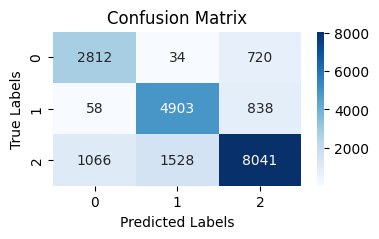

{'Accuracy (%)': '78.78',
 'Precision (Weighted, %)': '79.27',
 'Recall (Weighted, %)': '78.78',
 'F1-Score (Weighted, %)': '78.81',
 'Log Loss (%)': '50.94',
 'Gini Index (%)': '82.18',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1124,
 'Type II Error Percentage': '5.62'}

In [146]:
# change batch size from 128 to 256 and epochs from 60 to 100.

X = dt.drop(['Credit_Score','Customer_ID'], axis=1)
y = dt['Credit_Score']

# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(                        
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Further stratified split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)
from imblearn.over_sampling import SMOTE
# Resample the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train = to_categorical(y_train, num_classes=3) 
y_val = to_categorical(y_val, num_classes=3) 

# Scale the training, validation, and test sets
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)  

Epoch 1/100
225/225 [==============================] - 25s 100ms/step - loss: 0.7185 - accuracy: 0.7009 - val_loss: 0.7089 - val_accuracy: 0.6862
Epoch 2/100
225/225 [==============================] - 22s 100ms/step - loss: 0.6151 - accuracy: 0.7449 - val_loss: 0.6939 - val_accuracy: 0.6939
Epoch 3/100
225/225 [==============================] - 20s 90ms/step - loss: 0.5947 - accuracy: 0.7537 - val_loss: 0.6807 - val_accuracy: 0.7006
Epoch 4/100
225/225 [==============================] - 19s 83ms/step - loss: 0.5813 - accuracy: 0.7567 - val_loss: 0.6751 - val_accuracy: 0.7039
Epoch 5/100
225/225 [==============================] - 18s 80ms/step - loss: 0.5706 - accuracy: 0.7619 - val_loss: 0.6659 - val_accuracy: 0.7081
Epoch 6/100
225/225 [==============================] - 19s 83ms/step - loss: 0.5612 - accuracy: 0.7646 - val_loss: 0.6591 - val_accuracy: 0.7117
Epoch 7/100
225/225 [==============================] - 18s 81ms/step - loss: 0.5555 - accuracy: 0.7682 - val_loss: 0.6667 - val_

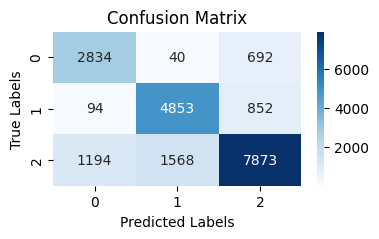

{'Accuracy (%)': '77.80',
 'Precision (Weighted, %)': '78.49',
 'Recall (Weighted, %)': '77.80',
 'F1-Score (Weighted, %)': '77.86',
 'Log Loss (%)': '53.07',
 'Gini Index (%)': '80.74',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 1288,
 'Type II Error Percentage': '6.44'}

In [10]:
# deepen further the model

X = dt.drop(['Credit_Score','Customer_ID'], axis=1)
y = dt['Credit_Score']

# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(                        
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Further stratified split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)
from imblearn.over_sampling import SMOTE
# Resample the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train = to_categorical(y_train, num_classes=3) 
y_val = to_categorical(y_val, num_classes=3) 

# Scale the training, validation, and test sets
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=100,
    batch_size=512,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)  

We now try to group the data by customer ID, split the dataset by customers, and train a  CNN to capture local patterns within the 8 entities per customer.
  

Epoch 1/100
59/59 [==============================] - 18s 179ms/step - loss: 0.8132 - accuracy: 0.7091 - val_loss: 0.8201 - val_accuracy: 0.6380
Epoch 2/100
59/59 [==============================] - 10s 169ms/step - loss: 0.5473 - accuracy: 0.7921 - val_loss: 0.7668 - val_accuracy: 0.6860
Epoch 3/100
59/59 [==============================] - 11s 179ms/step - loss: 0.4713 - accuracy: 0.8152 - val_loss: 0.7919 - val_accuracy: 0.6990
Epoch 4/100
59/59 [==============================] - 11s 180ms/step - loss: 0.4474 - accuracy: 0.8187 - val_loss: 0.7861 - val_accuracy: 0.7180
Epoch 5/100
59/59 [==============================] - 10s 167ms/step - loss: 0.4219 - accuracy: 0.8252 - val_loss: 0.7577 - val_accuracy: 0.7360
Epoch 6/100
59/59 [==============================] - 11s 180ms/step - loss: 0.4007 - accuracy: 0.8328 - val_loss: 0.8211 - val_accuracy: 0.7370
Epoch 7/100
59/59 [==============================] - 11s 180ms/step - loss: 0.3897 - accuracy: 0.8337 - val_loss: 0.7803 - val_accuracy:

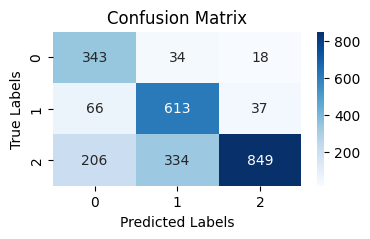

{'Accuracy (%)': '72.20',
 'Precision (Weighted, %)': '78.89',
 'Recall (Weighted, %)': '72.20',
 'F1-Score (Weighted, %)': '72.57',
 'Log Loss (%)': '84.01',
 'Gini Index (%)': '78.76',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 272,
 'Type II Error Percentage': '10.88'}

In [11]:
#  Use Convolutional Neural Network (CNN) on the grouped data.

X = dt.drop(['Credit_Score', 'Customer_ID'], axis=1).values
y = dt['Credit_Score'].values
y = y[::8]
X = np.array(X)

# Reshape X to (samples, entities, features)
X = X.reshape(-1, 8, 39)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Further stratified split for validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# Resample the training data with SMOTE 
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten temporarily for SMOTE
smote = SMOTE(random_state=42)
X_train_flat, y_train = smote.fit_resample(X_train_flat, y_train)
X_train = X_train_flat.reshape(-1, 8, 39)  # Reshape back to original dimensions

# Convert y to one-hot encoding for the CNN
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

# Scale the features
sc = StandardScaler()
X_train = X_train.reshape(-1, 39)  # Flatten for scaling
X_val = X_val.reshape(-1, 39)
X_test = X_test.reshape(-1, 39)

X_train = sc.fit_transform(X_train).reshape(-1, 8, 39)  # Reshape back after scaling
X_val = sc.transform(X_val).reshape(-1, 8, 39)
X_test = sc.transform(X_test).reshape(-1, 8, 39)

# Define CNN Model
model = Sequential([
    Conv1D(256, kernel_size=3, activation='relu', padding='same',input_shape=(8, 39)),
    BatchNormalization(),
    Dropout(0.25),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.25),
    GlobalMaxPooling1D(),  # Reduce to a single vector per sample
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Multiclass classification loss
    metrics=['accuracy']
)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Train the CNN
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1)  # Final class predictions
y_true = y_test  # True labels

# Example evaluation function call
score(y_true, y_pred, y_proba)


In [25]:
# Group by customer id and aggregate dataset
                                        
                                        # features that don't take unique values for each customer.
grouped = dt.groupby('Customer_ID').agg({'Delay_from_due_date': 'mean', 'Changed_Credit_Limit': 'mean',
                                        'Num_Credit_Inquiries':'max', 'Outstanding_Debt':'mean',
                                        'Credit_Utilization_Ratio':'mean', 'Credit_History_Age':'max',
                                       'Amount_invested_monthly':'mean', 'Monthly_Balance':'mean',
                                        'Payment_of_Min_Amount':'mean', 'Payment_Behaviour':'last', 'Debt_to_Income_Ratio':'mean',

                                        # features with a single value per customer.
                                       'Occupation':'first', 'Annual_Income':'first', 'Monthly_Inhand_Salary':'mean',
                                       'Num_Bank_Accounts':'first', 'Num_Credit_Card':'first' , 'Age':'first',
                                        'Interest_Rate':'first', 'Num_of_Loan':'first', 'Num_of_Delayed_Payment':'first',
                                        'Credit_Mix':'first', 'Total_EMI_per_month':'first',
                                         'Credit_Score':'first'}).reset_index()   
grouped

,Customer_ID,Delay_from_due_date,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Amount_invested_monthly,Monthly_Balance,Payment_of_Min_Amount,...,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Age,Interest_Rate,Num_of_Loan,Num_of_Delayed_Payment,Credit_Mix,Total_EMI_per_month,Credit_Score
0,CUS_0x1000,62.250,1.880,11.0,1562.91,33.477546,129.0,158.549750,335.375339,3.000,...,2706.161667,6,5,17.0,27,2,25.0,1,42.941090,2
1,CUS_0x1009,7.250,9.730,4.0,202.68,29.839984,372.0,146.679375,428.743153,2.875,...,4250.390000,6,5,26.0,17,4,18.0,2,108.366467,2
2,CUS_0x100b,13.500,10.965,4.0,1030.20,34.841449,190.0,1711.742875,781.229780,1.125,...,9549.782500,1,4,18.0,1,0,7.0,3,0.000000,1
3,CUS_0x1011,27.250,14.170,7.0,473.14,27.655897,190.0,1522.178250,332.642843,2.875,...,5208.872500,3,3,44.0,17,3,15.0,2,123.434939,2
4,CUS_0x1013,12.500,1.705,3.0,1233.51,31.933940,214.0,355.442500,472.781003,1.125,...,7962.415000,3,3,44.0,6,3,9.0,3,228.018084,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0xff3,12.250,8.485,5.0,1229.08,32.889398,208.0,83.918625,271.671559,1.000,...,1176.398750,0,6,55.0,2,3,9.0,3,33.299764,0
12496,CUS_0xff4,15.875,8.205,5.0,758.44,32.598257,225.0,152.775750,259.981171,2.875,...,2415.855000,8,7,37.0,14,5,13.0,2,101.328637,2
12497,CUS_0xff6,-0.125,11.900,2.0,338.30,33.258053,299.0,1785.239250,603.570680,1.000,...,9727.326667,5,6,19.0,1,2,4.0,3,126.638453,2
12498,CUS_0xffc,45.375,9.320,13.0,1300.13,34.722108,158.0,1386.651375,339.951776,3.000,...,5218.097500,6,8,17.0,27,8,16.0,1,272.809169,1


Epoch 1/100
118/118 [==============================] - 4s 14ms/step - loss: 0.8209 - accuracy: 0.6337 - val_loss: 0.6881 - val_accuracy: 0.7190
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 0.6261 - accuracy: 0.7507 - val_loss: 0.6064 - val_accuracy: 0.7260
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 0.5600 - accuracy: 0.7772 - val_loss: 0.5823 - val_accuracy: 0.7280
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 0.5362 - accuracy: 0.7886 - val_loss: 0.5665 - val_accuracy: 0.7350
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 0.5190 - accuracy: 0.7891 - val_loss: 0.5543 - val_accuracy: 0.7580
Epoch 6/100
118/118 [==============================] - 1s 10ms/step - loss: 0.5027 - accuracy: 0.7990 - val_loss: 0.5392 - val_accuracy: 0.7490
Epoch 7/100
118/118 [==============================] - 1s 9ms/step - loss: 0.4957 - accuracy: 0.8017 - val_loss: 0.5137 - val_accuracy: 0.76

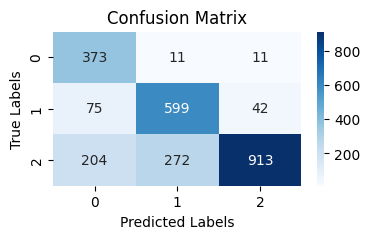

{'Accuracy (%)': '75.40',
 'Precision (Weighted, %)': '81.00',
 'Recall (Weighted, %)': '75.40',
 'F1-Score (Weighted, %)': '75.81',
 'Log Loss (%)': '50.73',
 'Gini Index (%)': '83.02',
 "Type II Error (Predicted 'Good' but Actually 'Bad/Standard')": 279,
 'Type II Error Percentage': '11.16'}

In [41]:
# Apply Sequential model on the grouped dataset to reduce training time.

X = grouped.drop(['Credit_Score','Customer_ID'], axis=1)
y = grouped['Credit_Score']


# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Further stratified split of the training set (90% train, 10% validation from training data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

# Resample the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train = to_categorical(y_train, num_classes=3) 
y_val = to_categorical(y_val, num_classes=3) 


# Scale the training, validation, and test sets
sc = StandardScaler()
X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.fit_transform(X_test[numerical_cols])
X_val[numerical_cols] = sc.fit_transform(X_val[numerical_cols])

model=Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multiclass classification
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=100,
    batch_size=128,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_proba = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_proba, axis=1) # final prediction 
y_true = np.array(y_test)    # true label
score(y_true, y_pred,y_proba)  

This model has almost the same performance with the best model we have seen so far but with a lot lower running time. 

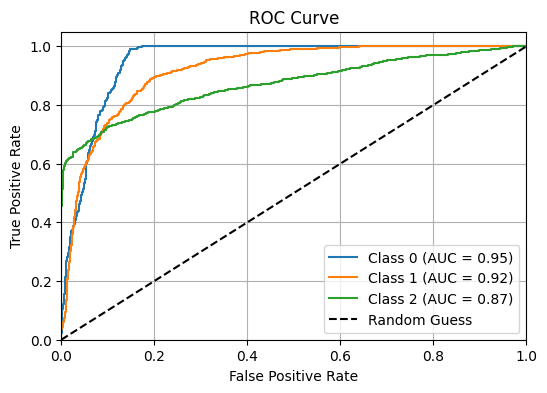

In [31]:
# Plot the ROC-CURVE 
ROC_Curve(y_true, y_proba)

In [40]:
explainer = shap.KernelExplainer(model=model.predict, data=X.head(60), link="identity")
shap_values = explainer.shap_values(X=X.iloc[0:60, :], nsamples=100,verbose=0)

Summary plot for Class: Good


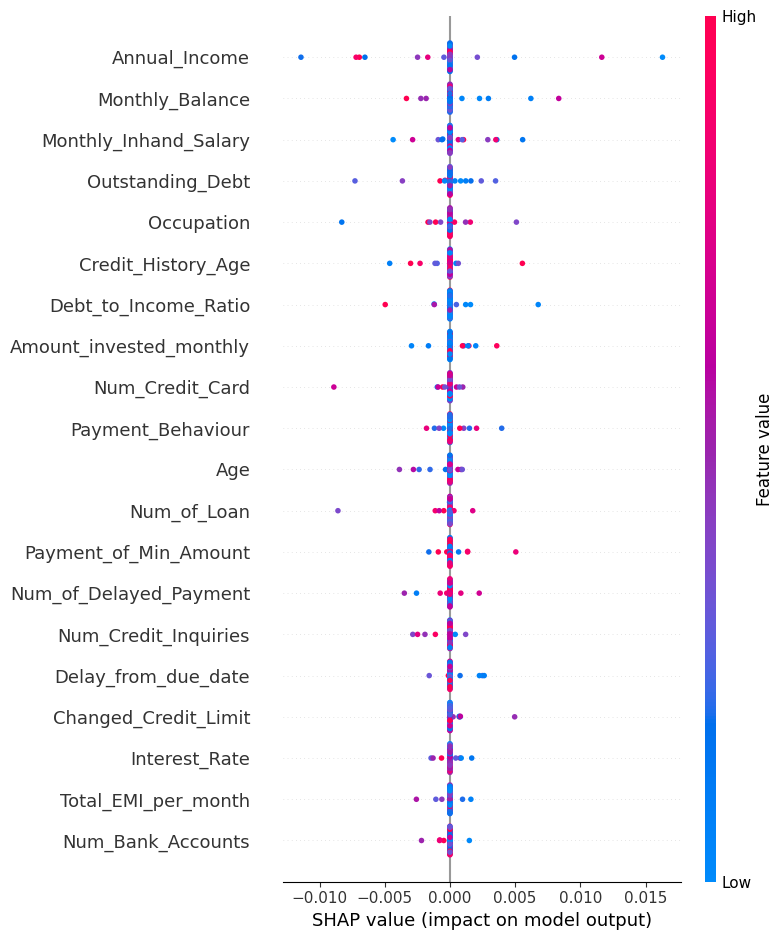

In [36]:
# Summary plot for Class 0
print( 'Summary plot for Class: Good')
shap.summary_plot(shap_values = shap_values[:,:,0],features = X_test.iloc[0:60,:], feature_names=X_test.columns)

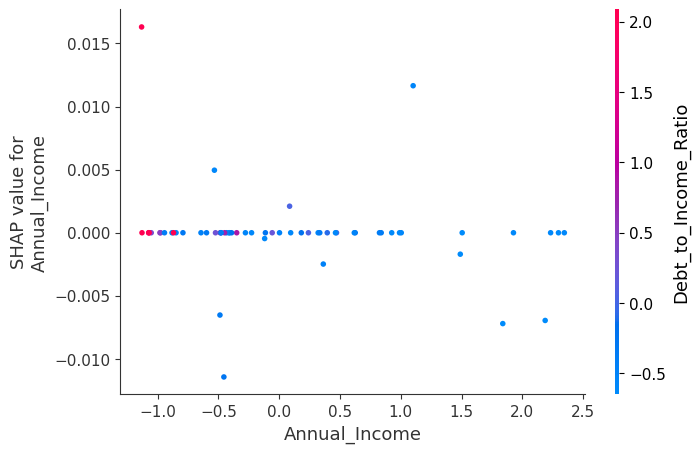

In [39]:
# Dependence Plot for Annual Income and Debt to income ratio.
shap.dependence_plot("Annual_Income", shap_values[:,:,0], X_test.iloc[0:60,:])

As the Annual Income is getting higher, the Debt to income ratio drops. 